In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")

%matplotlib inline
%load_ext autoreload
%autoreload 2

import datagenerators as dg

# Introduction

One day a team lead notices that some members of their teamwear cool hats, and that these members of the team tend to be more productive. Being data drive, the team lead starts to record whether or not a team member wears a cool hat ($X=1$ for a cool hat, $X=0$ for no cool hat) and whether or not they are productive ($Y=1$ for productive, $Y=0$ for unproductive).

After making observations for a week, they end up with a dataset like the following:

In [2]:
observed_data_0 = dg.generate_dataset_0()

observed_data_0.head()

,x,y
0,1,0
1,1,0
2,1,0
3,1,1
4,1,0


The first question the team lead asks is: are people wearing cool hats more likely to be productive? This means estimating the quantity

$P(Y=1|X)$

which we can do directly from the data:

In [3]:
def estimate_uplift(ds):
    base = ds[ds.x == 0]
    variant = ds[ds.x == 1]
    
    delta = variant.y.mean() - base.y.mean()
    delta_std = np.sqrt(
        variant.y.var() / variant.shape[0] + 
        base.y.var() / base.shape[0])
    
    return delta, delta_std

estimate_uplift(observed_data_0)

(-0.023444399839421926, 0.044802562820873609)

It looks like it does. 

To be sure, we can even run a statistical test:

In [4]:
from scipy.stats import chi2_contingency

contingency_table = (
    observed_data_0
    .assign(placeholder=1)
    .pivot_table(index="x", columns="y", values="placeholder", aggfunc="sum")
    .values
)

_, p, _, _ = chi2_contingency(contingency_table, lambda_="log-likelihood")

# p-value
p

0.66399892662360505

That's one small p-value. [Statistians would be proud](https://www.nature.com/articles/s41562-017-0189-z).

Our team lead now decides that this is enough evidence to require everyone to wear really cool hats, but being good data scientists, we stop them and say no - let's run a [randomized control trial](https://en.wikipedia.org/wiki/Randomized_controlled_trial).

In [5]:
def run_ab_test(datagenerator, n_samples=500):
    n_samples_a = int(n_samples / 2)
    n_samples_b = n_samples - n_samples_a
    set_X = np.concatenate([np.ones(n_samples_a), np.zeros(n_samples_b)]).astype(np.int64)
    ds = datagenerator(n_samples=n_samples, set_X=set_X)
    return estimate_uplift(ds)

run_ab_test(dg.generate_dataset_0)

(0.18000000000000005, 0.043973705176934448)

Suddenly, it looks like the direction of the effect of wearing cool hats has reversed. 

# Definitions of Causality 

The previous example shows the old statistics saying: 

[**Correlation Does Not Imply Causation**](https://xkcd.com/552/).

["Causality"](https://plato.stanford.edu/entries/causation-metaphysics/) is a vague, philosophical sounding word, so to be precise, when I talk about causality in the following, I am talking about how the distribution of one random variable changes when we force another random variable to take a certain value. I will call the act of forcing a variable to take a certain value an Intervention.

In the previous example, when we make no intervention on the system, we have an observational distribution of $Y$, conditioned on the fact we observe $X$:

$P(Y|X)$

When we force people to wear cool hats, we are making an intervention. The distribution of $Y$ is then given by the _interventional_ distribution 

$P(Y|\hbox{do}(X))$

Where, in general these two are not the same.

The question these notes will try and answer is how we can reason about the interventional distribution, when we only have access to observational data.

# Potential Outcomes 

One way to approach this problem is to introduce two new random variables to our system: $Y_{0}$ and $Y_{1}$, known as the [Potential Outcomes](http://www.stat.unipg.it/stanghellini/rubinjasa2005.pdf). We imagine that these variables exist, and can be treated as any other random variable - the only difference is that they are never directly observed. $Y$ is defined in terms of 

 - $Y = Y_{1}$ when $X=1$
 - $Y = Y_{0}$ when $X=0$
 
This shifts the problem from one about how distributions change under the intervention, to one about censored values, drawn i.i.d. from some underlying distribution.
 
A quantity we often care about when dealing with this distribution is the [Average Treatment Effect](https://en.wikipedia.org/wiki/Average_treatment_effect):

$\Delta = E[Y_{1} - Y_{0}]$

When we run and A/B test and compare the means of each group, this is directly the quantity we are measuring. 

If we just try and estimate this quantity directly from the observational distribution, we get:

$\Delta_{bad} = E[Y|X=1] - E[Y|X=0] \\
= E[Y_{1}|X=1] - E[Y_{0}|X=0] \\
\neq \Delta$

This is not generally equal to the true ATE because:

$E[Y_{1}|X=1] \neq E[Y_{1}]$

$\def\ci{\perp\!\!\!\perp}$


# Making Assumptions

When we A/B test, we randomize the assignment of $X$. This has the effect of allowing us to choose which variable of $Y_{1}$ or $Y_{0}$ is revealed to us. This makes the outcome independent of $X$. We write this as

$Y_{1}, Y_{0} \ci X$

Which means that the distribution of $X, Y_{0}, Y_{1}$ factorizes as

$P(X, Y_{0}, Y_{1}) = P(X)P(Y_{0}, Y_{1})$

If this independence holds then

$E[Y_{1}|X=1] = E[Y_{1}]$

If we want to estimate the ATE using observational data, we need to use other information we have about the samples - specifically we need to **assume** that we have enough additional information to completely explain the choice of treatment each subject.

If we call the additional information the random variable $Z$, we can write this assumption as

$Y_{1}, Y_{0} \ci X | Z$

or

$P(X, Y_{0}, Y_{1}| Z) = P(X|Z)P(Y_{0}, Y_{1}|Z)$

The quality of any prediction you make depends on exactly how much you trust this assumption. [Simpson's Paradox](http://www.degeneratestate.org/posts/2017/Oct/22/generating-examples-of-simpsons-paradox/) is an extreme example of the fact that if $Z$ does not give contain all confound variables, then any inference we make could be wrong. [Facebook have a good paper comparing different causal inference approaches with direct A/B test that show this](https://www.kellogg.northwestern.edu/faculty/gordon_b/files/kellogg_fb_whitepaper.pdf).

Once we have made this assumption there are a number of techniques for approaching this. I will outline a few of simpler approaches in the rest of the post, but keep in mind that this is a area of ongoing research.

# Modeling the Counterfactual

From the above, it should be clear that if know $Y_{0}$ and $Y_{1}$, we can estimate the ATE. So why not just try and model them directly? Specifically build estimators: 
 
 - $\hat{Y}_{0}(Z) = E[Y|Z, X=0]$
 - $\hat{Y}_{1}(Z) = E[Y|Z, X=1]$. 
 
If we can model these two quantities, we can estimate the ATE as:

$\Delta = \frac{1}{N}\sum_{i}(\hat{Y}_{1}(z_{i}) - \hat{Y}_{0}(z_{i}))$

The success of this approach depends on how well we can model the potential outcomes. To see it in action, let's use the following data generating process:

Observed ATE: 0.123 (0.051)
Real ATE: -0.452 (0.041)


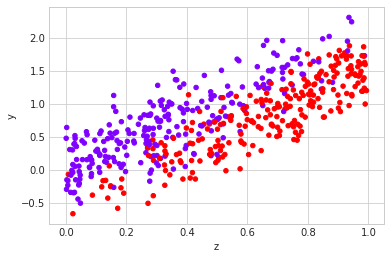

In [6]:
observed_data_1 = dg.generate_dataset_1()

observed_data_1.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

print("Observed ATE: {:.3f} ({:.3f})".format(*estimate_uplift(observed_data_1)))
print("Real ATE: {:.3f} ({:.3f})".format(*run_ab_test(dg.generate_dataset_1, n_samples=1000)))


The simplest type of model we can use is a linear model. Specifically we could assume 

$Y_{0} = \alpha + \beta Z + \epsilon$

$Y_{1} = Y_{0} + \gamma$

If this is accurate, fitting the model

$Y = \alpha + \beta Z + \gamma X$

to the data using linear regression will give us an estimate of the ATE.

The `causalinference` package gives us a simple interface to do this:

In [7]:
from causalinference import CausalModel

cm = CausalModel(
    Y=observed_data_1.y.values, 
    D=observed_data_1.x.values, 
    X=observed_data_1.z.values)

cm.est_via_ols()

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.511      0.031    -16.552      0.000     -0.572     -0.451
           ATC     -0.525      0.035    -15.211      0.000     -0.593     -0.457
           ATT     -0.497      0.035    -14.209      0.000     -0.566     -0.429



The package has done will in identifying the correct ATE - which is good, but the data generating process was specifically designed to meet the assumptions. Let's look at a few cases where it might fail.

This first is when the effect is not simply additive:

Observed ATE: 0.700 (0.054)
Real ATE: 0.558 (0.002)


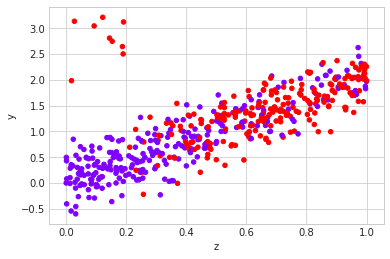

In [8]:
observed_data_2 = dg.generate_dataset_2()

observed_data_2.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

print("Observed ATE: {:.3f} ({:.3f})".format(*estimate_uplift(observed_data_2)))
print("Real ATE: {:.3f} ({:.3f})".format(*run_ab_test(dg.generate_dataset_2, n_samples=1000000)))

In [9]:
cm = CausalModel(
    Y=observed_data_2.y.values, 
    D=observed_data_2.x.values, 
    X=observed_data_2.z.values)

cm.est_via_ols()

print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.262      0.076      3.442      0.001      0.113      0.411
           ATC      0.421      0.113      3.743      0.000      0.201      0.642
           ATT      0.080      0.044      1.833      0.067     -0.006      0.166



Usually this can be overcome by using more powerful estimators . A simple, non-parametric approach, is the technique of [matching](https://en.wikipedia.org/wiki/Matching_%28statistics%29). The idea is to find for each sample which received the treatment, a similar samples which did not receive the treatment, and to directly compare these values. Exactly what you mean by "similar" will depend on your specific usecase., 

The package `causalinference` implements matching by selecting for each unit, with replacement, the most similar unit from the other treatment group and using the difference between these two units to calculate the ATE. By default, the choice of match is chosen to be the nearest neighbour in covariate space $Z$, with the distances weighted by inverse variance of each dimension.

There are options to change the number of units compared and the weighting of each dimension in the match. For more details, see the [documentation](http://laurence-wong.com/software/matching).

We can compute the matching estimate with the following code

In [10]:
cm = CausalModel(
    Y=observed_data_2.y.values, 
    D=observed_data_2.x.values, 
    X=observed_data_2.z.values)

cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.545      0.131      4.170      0.000      0.289      0.802
           ATC      0.998      0.140      7.118      0.000      0.723      1.273
           ATT      0.030      0.181      0.168      0.867     -0.325      0.386



The confidence intervals around our estimate now contain the true ATE.

# Covariate Imbalance

A more difficult problem to deal with is when the covariates you are using are imbalanced: when there are areas of covariate space which contains only the treated or untreated samples. Here we have to extrapolate the effect of the treatment - which will depend heavily on assumptions model we use. 

The example below demonstrates this:

Observed ATE: -0.023 (0.027)
Real ATE: 1.001 (0.001)


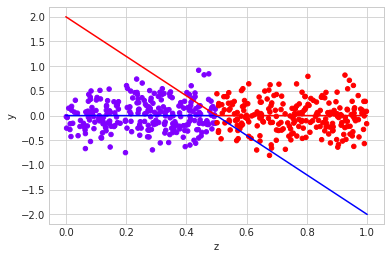

In [24]:
observed_data_3 = dg.generate_dataset_3()

observed_data_3.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

# actual response curves
z = np.linspace(0,1,100)
y0 =  np.where(z >= 0.5, -4*(z - 0.5), 0)
y1 =  np.where(z < 0.5,  -4*(z - 0.5), 0)
plt.plot(z,y0, "b")
plt.plot(z,y1, "r")


print("Observed ATE: {:.3f} ({:.3f})".format(*estimate_uplift(observed_data_3)))
print("Real ATE: {:.3f} ({:.3f})".format(*run_ab_test(dg.generate_dataset_3, n_samples=1000000)))

In [12]:
cm = CausalModel(
    Y=observed_data_3.y.values, 
    D=observed_data_3.x.values, 
    X=observed_data_3.z.values)

cm.est_via_matching()

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.003      0.396     -0.007      0.994     -0.780      0.774
           ATC      0.345      0.522      0.661      0.508     -0.677      1.367
           ATT     -1.035      0.173     -5.976      0.000     -1.374     -0.695



The matching estimator actually makes our prediction worse.

This example might seem contrived - that's because it is. There are a few examples at the end which are more realistic.

# Propensity Score

The Propensity score is a estimate of how likely it is for a subject to have ended up with the treatment, given the covariates:

$\hat{p}(Z) = P(X|Z)$

We can estimate this however we like, but once we have it there are a number of things we can do with it.


## Inverse Propensity Score Weighting

Remember that the problem of measuring causal inference is that we want to know the quantity $E[Y_{i}]$, but we only have access to samples from $E[Y_{i}|X=i]$.

The probability of a potential outcome can be expanded to give

$P(Y_{i}) = P(Y_{i}| X = i)P(X = i)$

This suggests that we can estimate the true 

$E[Y_{i}] = E[\frac{Y_{i}}{P(X=i)}|X=i]$

Which gives us the inverse propensity score weight estimator:

$\Delta_{IPS} = \frac{1}{N}\left(\sum_{i \in 1} \frac{y_{i}}{\hat{p}(z_{i})} - \sum_{i \in 0} \frac{y_{i}}{1 - \hat{p}(z_{i})}\right)$

Let's see how it does one of our previous datasets:

Observed ATE: 0.156 (0.049)
Real ATE: -0.500 (0.001)


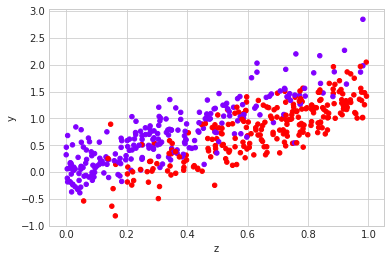

In [81]:
observed_data_1 = dg.generate_dataset_1()

observed_data_1.plot.scatter(x="z", y="y", c="x", cmap="rainbow", colorbar=False)

print("Observed ATE: {:.3f} ({:.3f})".format(*estimate_uplift(observed_data_1)))
print("Real ATE: {:.3f} ({:.3f})".format(*run_ab_test(dg.generate_dataset_1, n_samples=1000000)))

In [82]:
df = observed_data_1

from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
X = df.z.values.reshape(-1,1)
y = df.x.values
lg.fit(X,y)

propensity = lg.predict_proba(X)[:,1]

df["ips"] = np.where(
    df.x == 1, 
    1 / propensity,
    1 / (1 - propensity))
df["ipsw"] = df.y * df.ips

ipse = (
      df[df.x == 1]["ipsw"].sum() 
    - df[df.x == 0]["ipsw"].sum()
) / df.shape[0]

ipse

-0.36028993923786595

It does better than our naive estimator, but is not perfect. 

(0, 1)

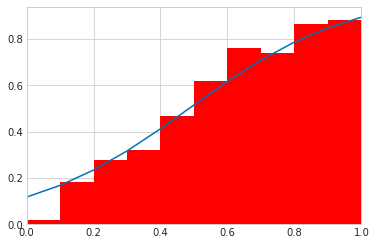

In [83]:
bins =  np.linspace(0,1,11)
df["z_binned"] = np.digitize(df.z, bins)

y_true = df.groupby("z_binned").x.mean().sort_index().values
y_pred = lg.predict_proba(bins.reshape(-1,1))[:,1]

plt.plot(bins, y_pred)
plt.bar(bins[:-1], y_true, width=1 / (bins.shape[0]-1), color="r", align="edge")
plt.xlim(0,1)

# Choice of Covariates

So far I haven't talked about the choice of covariates to use in adjustment - we've just assumed that they exist, are provided for us, and leave the problem completely unconfounded. In reality we don't have such guarantees, we might be missing confounders, or worse: it is possible to condition on variables which end up confounding what was otherwise an unconfounded test.

To understand these situations, we need to move beyond the potential outcome model and look at the structure of the underlying causal model. The language for describing this are [structural causal models](https://en.wikipedia.org/wiki/Causal_model).

# Exercises 

To try out some of the techniques in this post, I have included a number of other data generators below. 

# Final Notes

I hope that the conclusion of these notes is that Causality is difficult, and always relies on a number of untestable assumptions. Any conclusions you draw should only be trusted as much as you trust your assumptions. 

It is also worth ending with some of the things I haven't explicitly discussed:

 - **Time** plays an important role in any physical theory of causality. It also complicates our analysis. When variables of interest are values aggregated over some time period, it is possible for strange relationships to occur. Consider the example of the relationship between the amount of stock a shop has and it's sales - if stock is the average amount held during a day, it is possible for high sales to be correlated with low stock (as the stock has sold during the day). That said, information from time series can be used to construct counter factual time series. A good example is google's [CausalImpact package](https://google.github.io/CausalImpact/CausalImpact.html).
 
 - **Independence** in each example we've seen, it has been assumed that whether or on a subject received a treatment did not affect any other outcome. This is sometimes called the Stable Unit Treatment Value Assumption.
 
 - [**Instrument Variables** ](https://en.wikipedia.org/wiki/Instrumental_variables_estimation) are another common tool for causal inference in economics. The idea is to use a variable which has has some influence on the treatment assignment, but not on the outcome to estimate the effect. 